# [Fig. 10] Consistency of the PAGES 2k ensemble

Here we apply notions of inter and intra-ensemble distance to measure the consistency of the [PAGES 2k (2019)](https://www.nature.com/articles/s41561-019-0400-0) ensemble of GMST reconstructions. The notebook reproduces Fig 10 of the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

import pens
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import gaussian_kde 
plt.style.use('default')
pens.set_style()

In [2]:
# PAGES 2k 2019 reconstruction files from https://www.ncei.noaa.gov/pub/data/paleo/pages2k/neukom2019temp/recons/recons.zip
ds = xr.open_dataset('../data/pages2k_ngeo19_recons.nc')
ds

<xarray.Dataset>
Dimensions:  (year: 2000, ens: 1000)
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 ... 1994 1995 1996 1997 1998 1999 2000
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
Data variables:
    LMRv2.1  (year, ens) float32 ...
    BHM      (year, ens) float64 ...
    DA       (year, ens) float64 ...
    CPS      (year, ens) float64 ...
    OIE      (year, ens) float64 ...
    PAI      (year, ens) float64 ...
    PCR      (year, ens) float64 ...
    M08      (year, ens) float64 ...

In [3]:
methods = []
for m in ds.data_vars:
    methods.append(m)
print(methods)

['LMRv2.1', 'BHM', 'DA', 'CPS', 'OIE', 'PAI', 'PCR', 'M08']


In [4]:
ens = {}
for tag in methods:
    ens[tag] = pens.EnsembleTS(time=ds.year, value=ds[tag].values, label=tag,
                              time_unit='year CE', value_name='GMST', value_unit='K')
    #ens[tag].plot_hdi()

## Comparing offline DA reconstructions

The PAGES 2k (2019) ensemble contains one reconstruction using the same offline DA approach as LMRv2.1, but a slightly different set of proxies annualized from April-March. Let us compare them here:

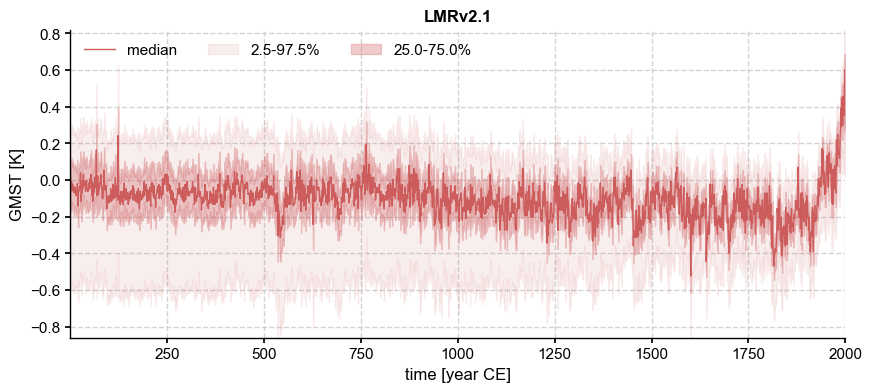

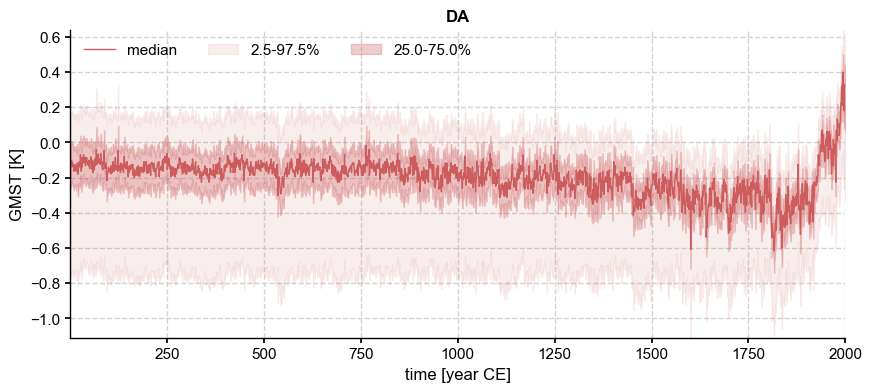

In [5]:
fig, ax = ens['LMRv2.1'].plot_qs(ylabel='GMST [K]')
fig, ax = ens['DA'].plot_qs(ylabel='GMST [K]')

Note the different y axes, with the PAGES 2k (2019) "DA" solution more spread out than LMR v2.1.  Once again we can compare one ensemble to a representative trace from the other (e.g. the median):

Text(0.5, 1.0, 'LMRv2.1 ensemble vs P2k19 DA median')

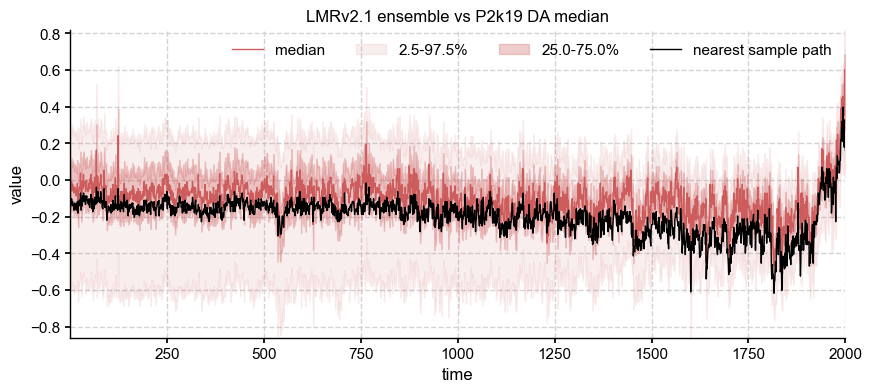

In [6]:
fig, ax = ens['LMRv2.1'].plot_qs()
ens['LMRv2.1'].sample_nearest(ens['DA'].get_median().value).plot(ax=ax, color='k', label='nearest sample path')
ax.legend(ncol=4)
ax.set_title('LMRv2.1 ensemble vs P2k19 DA median')

In [7]:
fig.savefig('../figures/PAGES2k_2019_DAvsLMR2.1_traces.pdf',dpi=200)

Differences are now more apparent between the medians, but are they fundamentally different?
Let us resample both of them, according to a power law with $\beta = 0.9$:

In [8]:
beta = 0.93
LMRv21_pl =  ens['LMRv2.1'].random_paths(model='power-law', param=beta, p=1000)
DA_pl = ens['DA'].random_paths(model='power-law', param=beta, p=1000)

100%|██████████| 1000/1000 [00:01<00:00, 701.26it/s]


In [9]:
DA_plume_dist = LMRv21_pl.plume_distance(y=DA_pl)

Computing inter-ensemble distance: 100%|██████████| 1000/1000 [00:30<00:00, 33.16it/s]


Computing inter-ensemble distance: 100%|██████████| 1000/1000 [00:00<00:00, 44025.44it/s]


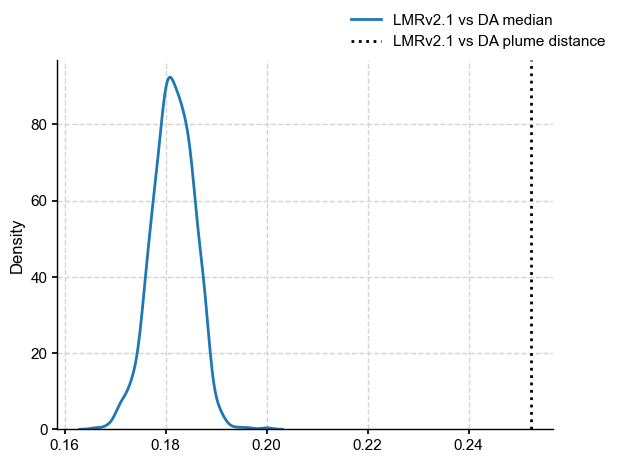

In [10]:
dDAmed=LMRv21_pl.distance(y=DA_pl.get_median().value)
fig, ax = plt.subplots()
sns.kdeplot(dDAmed, ax = ax, label='LMRv2.1 vs DA median')
ax.axvline(x=DA_plume_dist[0],linestyle=':',color='k',label='LMRv2.1 vs DA plume distance')
fig.legend()

## Pairwise comparisons

We now carry out pairwise comparisons. Of the PAGES 2k reconstructions, the DA one is the only one that does not have an explicit temporal dependence, so it needs to be resampled. As before, we choose a power law with $\beta = 0.92$, suggested by LMRonline results:

In [11]:
ens['DA_rsmpl'] = ens['DA'].random_paths(model='power-law',param=beta,p=2000)
ens['LMR_rsmpl'] = LMRv21_pl 

100%|██████████| 2000/2000 [00:02<00:00, 721.05it/s]


(<Figure size 1200x400 with 1 Axes>,
 <Axes: title={'center': 'DA (power-law resampling)'}, xlabel='time [year CE]', ylabel='GMST [K]'>)

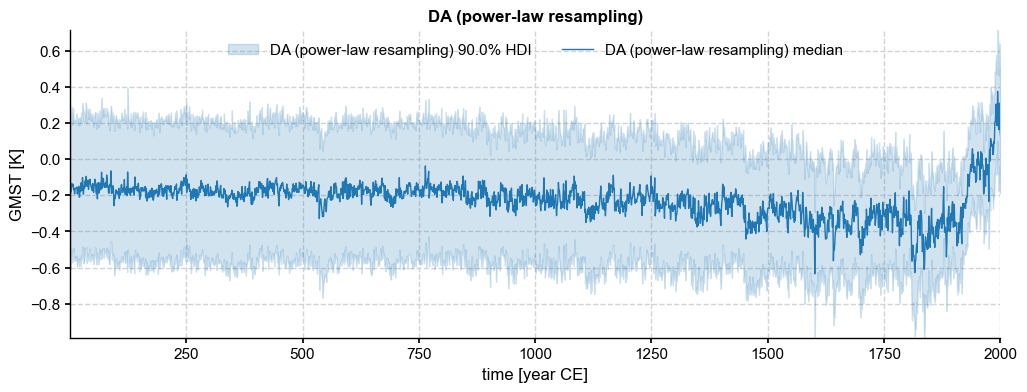

In [12]:
ens['DA_rsmpl'].plot_hdi()

### Traces + HDI only (for talks)

Text(0.5, 0.98, 'PAGES 2k (2019) reconstructions')

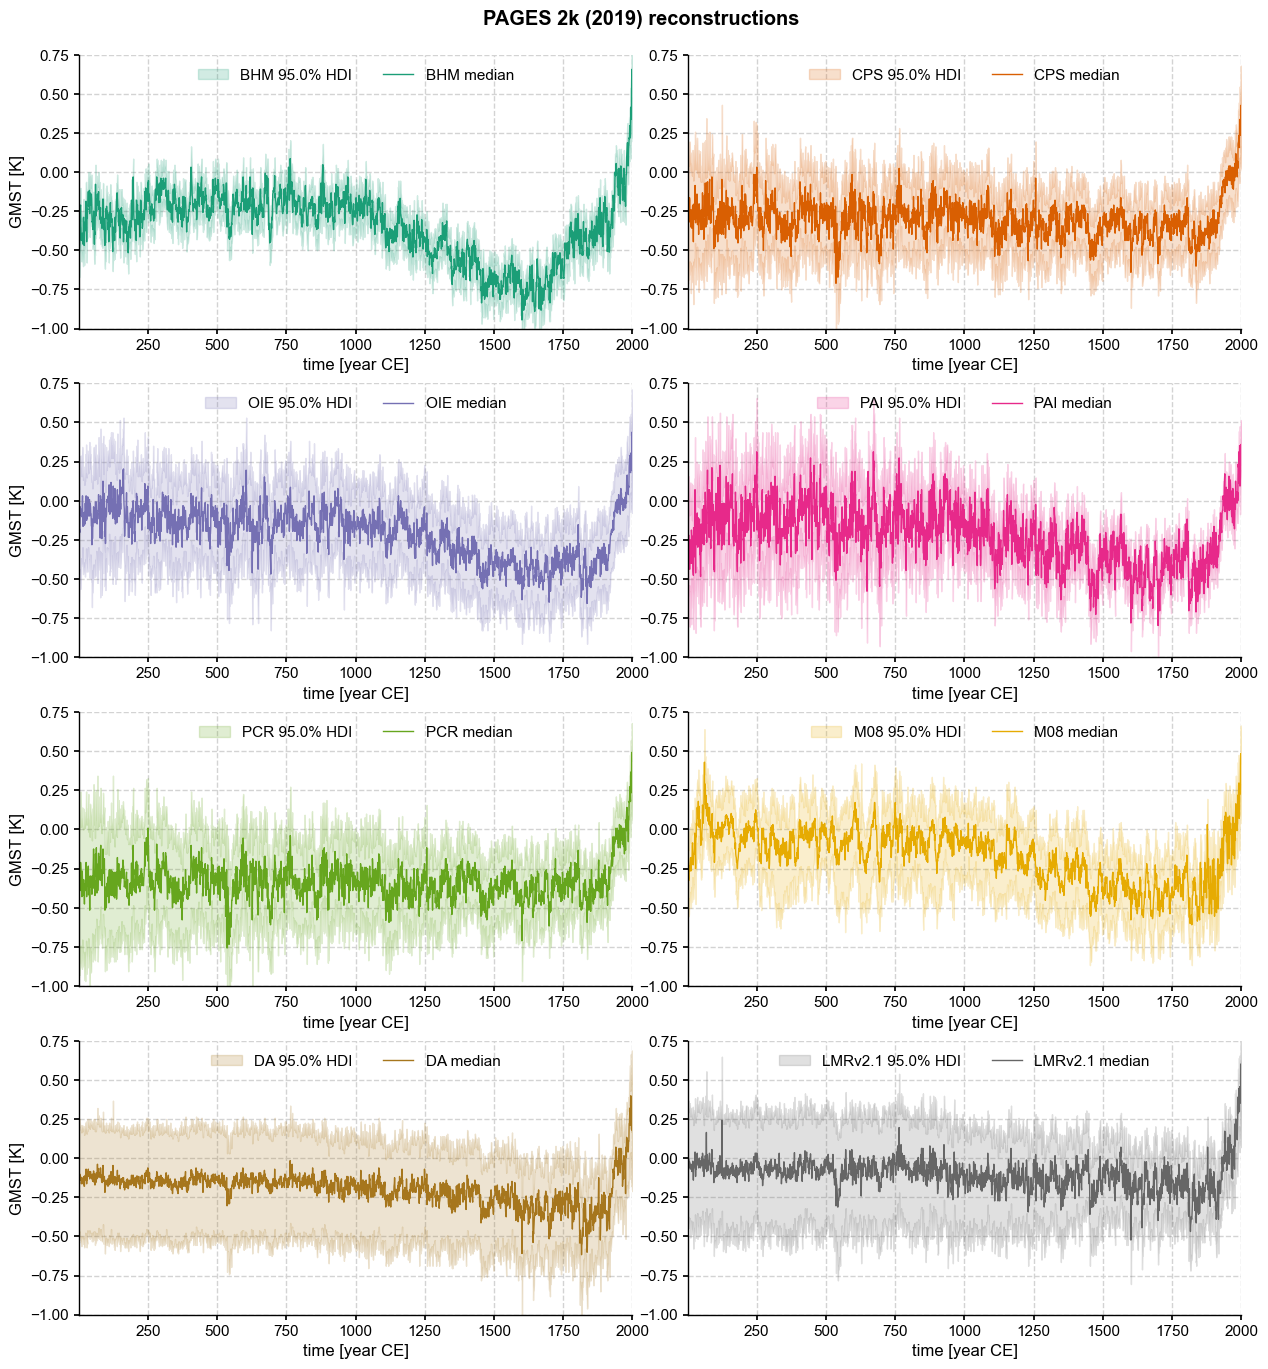

In [13]:
methds = ['BHM', 'CPS', 'OIE', 'PAI', 'PCR', 'M08','DA', 'LMRv2.1']
clr = plt.cm.Dark2(np.linspace(0,1,len(methds))) # define colors
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(4, 2, wspace=0.1, hspace=0.2,top=0.95)
ax = {}
for i, tag in enumerate(methds):
    ax[tag] = fig.add_subplot(gs[i])
    ylabel = None if (i % 2 == 0) else ''   
    ens[tag].plot_hdi(ax=ax[tag],prob=0.95,color=clr[i], title = '',
                      ylabel=ylabel, ylim=[-1.,0.75])
fig.suptitle('PAGES 2k (2019) reconstructions',fontweight='bold') 

In [14]:
fig.savefig('../figures/PAGES2k_2019_hdi.pdf',dpi=300)

In [15]:
DA_pl_intra_dist = ens['DA_rsmpl'].distance()
DA_pl_intra_dist_q95 = np.quantile(DA_pl_intra_dist,0.95)

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:53<00:00, 37339.66it/s]


In [16]:
methods2 = ['BHM', 'CPS', 'OIE', 'PAI', 'PCR', 'M08', 'LMR_rsmpl']
dist = {}
for method in methods2:
    dist[method] = ens['DA_rsmpl'].distance(y=ens[method],nsamples=1000)

Computing inter-ensemble distance: 100%|██████████| 1000/1000 [00:19<00:00, 51.76it/s]


Put all distances on the same figure:

### Combined figure (for paper)

In [17]:
N = len(methods2)
clr = plt.cm.Dark2(np.linspace(0,1,N)) # define colors

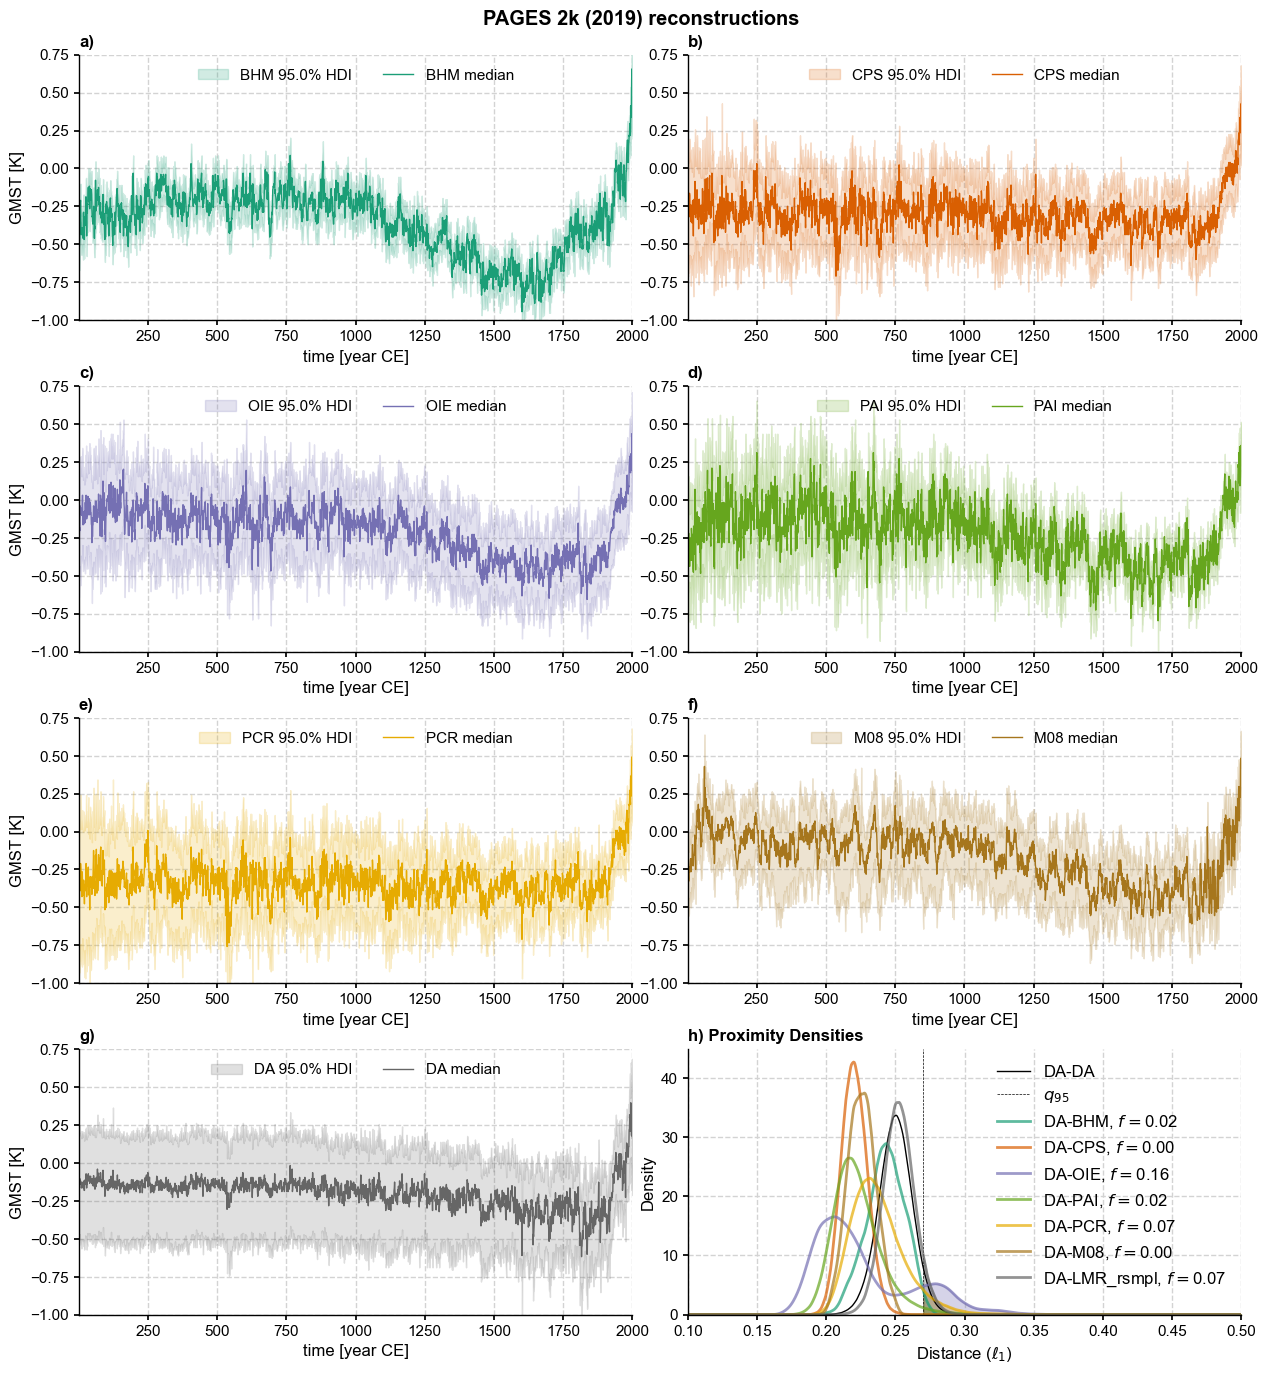

In [24]:
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(4, 2, wspace=0.1, hspace=0.25,top=0.95)
panel = [chr(i) for i in range(ord('a'),ord('h')+1)]
ax = {}
for i, tag in enumerate(['BHM', 'CPS', 'OIE', 'PAI', 'PCR', 'M08', 'DA']):
    ax[tag] = fig.add_subplot(gs[i])
    ylabel = None if (i % 2 == 0) else ''  # eliminate ylabels on the right side 
    ens[tag].plot_hdi(ax=ax[tag],prob=0.95,color=clr[i], title = '',
                      ylabel=ylabel, ylim=[-1.,0.75])
    ax[tag].set_title(panel[i]+')',loc='left',fontweight='bold') 
fig.suptitle('PAGES 2k (2019) reconstructions',fontweight='bold') 
# add distances
xd = np.linspace(0,0.5,1000)
bw = 'silverman' 
ax['dist'] = fig.add_subplot(gs[N])
sns.kdeplot(DA_pl_intra_dist,ax=ax['dist'],label='DA-DA',color = 'k',linewidth=1)
ax['dist'].axvline(x=DA_pl_intra_dist_q95,linestyle='--',color='k',linewidth=0.5,label='$q_{95}$')
for i, method in enumerate(methods2):
    kde = gaussian_kde(dist[method],bw_method=bw)
    prob = kde.integrate_box_1d(DA_pl_intra_dist_q95, xd.max()) # estimate probability of positive change
    # plotting the distribution
    xp = xd[xd>DA_pl_intra_dist_q95]
    ax['dist'].fill_between(xp, kde(xp),alpha=0.3, color=clr[i])
    ax['dist'].plot(xd, kde(xd), linewidth=2, alpha = 0.7,
                    label='DA-' + method + rf', $f=${prob:.2f}', color=clr[i])

ax['dist'].set_xlabel(r'Distance ($\ell_1$)')
ax['dist'].set_xlim([0.1,0.5])
ax['dist'].set_title(panel[N]+') Proximity Densities',loc='left',fontweight='bold') 
ax['dist'].legend(fontsize = 12)

In [25]:
fig.savefig('../figures/PAGES2k_2019_traces&dist.pdf',dpi=300)

### Distance distribution only (for talks)

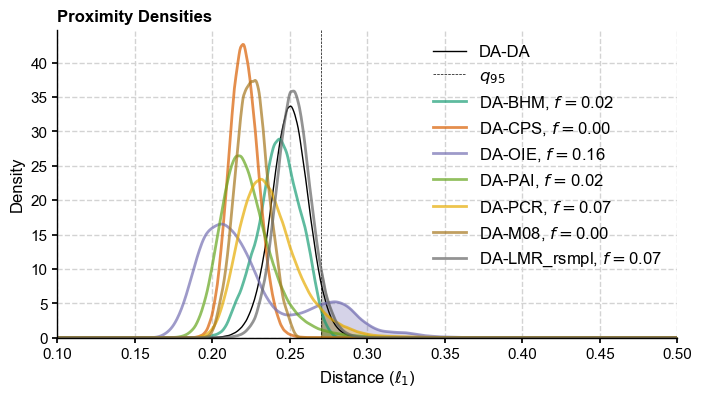

In [26]:
fig, ax = plt.subplots(figsize=(8,4))
# add distances
xd = np.linspace(0,0.5,1000)
bw = 'silverman' 
sns.kdeplot(DA_pl_intra_dist,ax=ax,label='DA-DA',color = 'k',linewidth=1)
ax.axvline(x=DA_pl_intra_dist_q95,linestyle='--',color='k',linewidth=0.5,label='$q_{95}$')
for i, method in enumerate(methods2):
    kde = gaussian_kde(dist[method],bw_method=bw)
    prob = kde.integrate_box_1d(DA_pl_intra_dist_q95, xd.max()) # estimate probability of positive change
    # plotting the distribution
    xp = xd[xd>DA_pl_intra_dist_q95]
    ax.fill_between(xp, kde(xp),alpha=0.3, color=clr[i])
    ax.plot(xd, kde(xd), linewidth=2, alpha = 0.7,
                    label='DA-' + method + rf', $f=${prob:.2f}', color=clr[i])

ax.set_xlabel(r'Distance ($\ell_1$)')
ax.set_xlim([0.1,0.5])
ax.set_title('Proximity Densities',loc='left',fontweight='bold') 
ax.legend(fontsize = 12)

In [27]:
fig.savefig('../figures/PAGES2k_2019_dist_only.pdf',dpi=300)